## Handsaker2025 data visualization

This notebook explores the raw data publicly available at NeMO (Neuroscience Multi-omic Archive), under accession dat-ztfn3cc.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import h5py
import scanpy as sc
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import math

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.cluster import SpectralClustering

from sklearn.decomposition import PCA

In [2]:
os.chdir('/pool01/')

data_dir = 'data/public/handsaker2025/'

snrna_counts_dir = f'{data_dir}Analysis_bag_2_Broad_Huntingtons_Caudate_2024_10xv3.1_snRNA-seq_Counts_Open/'
snrna_metadata_dir = f'{data_dir}Analysis_bag_4_Broad_Huntingtons_Caudate_2024_10xv3.1_snRNA-seq_Metadata_Open/'
cag_dir = f'{data_dir}Analysis_bag_6_Broad_Huntingtons_Caudate_2024_PacBio_Metadata_Open/'

### CAG length data (PACBio)

In [3]:
pacbio = pd.read_csv(f'{cag_dir}pacbio_deepdives_cells_unfiltered.txt', sep='\t')
pacbio.head()

,CELL_BARCODE,UMI,NREADS,READLENGTH,CAGLENGTH,CATEGORY,ALIGNSTART,ALIGNEND,DONOR,REGION,CELLTYPE
0,S05202_Caudate_DeepDive_rxn1_AATGGCTTCGTTGTTT,AAACAACGAAGCCATT.GTATAATCAGGC,918,769,43,EXON2,3074853.0,3075088.0,S05202,CD,astrocyte
1,S05202_Caudate_DeepDive_rxn1_GTCTACCCAGGTGTTT,AAACACCTGGGTAGAC.ACATATTTGAAG,1130,690,15,EXON2,3074853.0,3075088.0,S05202,CD,SPN
2,S05202_Caudate_DeepDive_rxn1_GACTATGGTCGAGTTT,AAACTCGACCATAGTC.CCTGACATTGGT,221,517,42,POLYA,3074853.0,3075088.0,S05202,CD,polydendrocyte
3,S05202_Caudate_DeepDive_rxn1_TGTGCGGAGGGTCTTT,AAAGACCCTCCGCACA.AACCAAAAAATA,177,1106,42,EXON2,3074853.0,3075088.0,S05202,CD,interneuron
4,S05202_Caudate_DeepDive_rxn1_AGATGAATCAGTCTTT,AAAGACTGATTCATCT.ATGGTTAATCCT,142,438,15,POLYA,3074853.0,3075088.0,S05202,CD,microglia


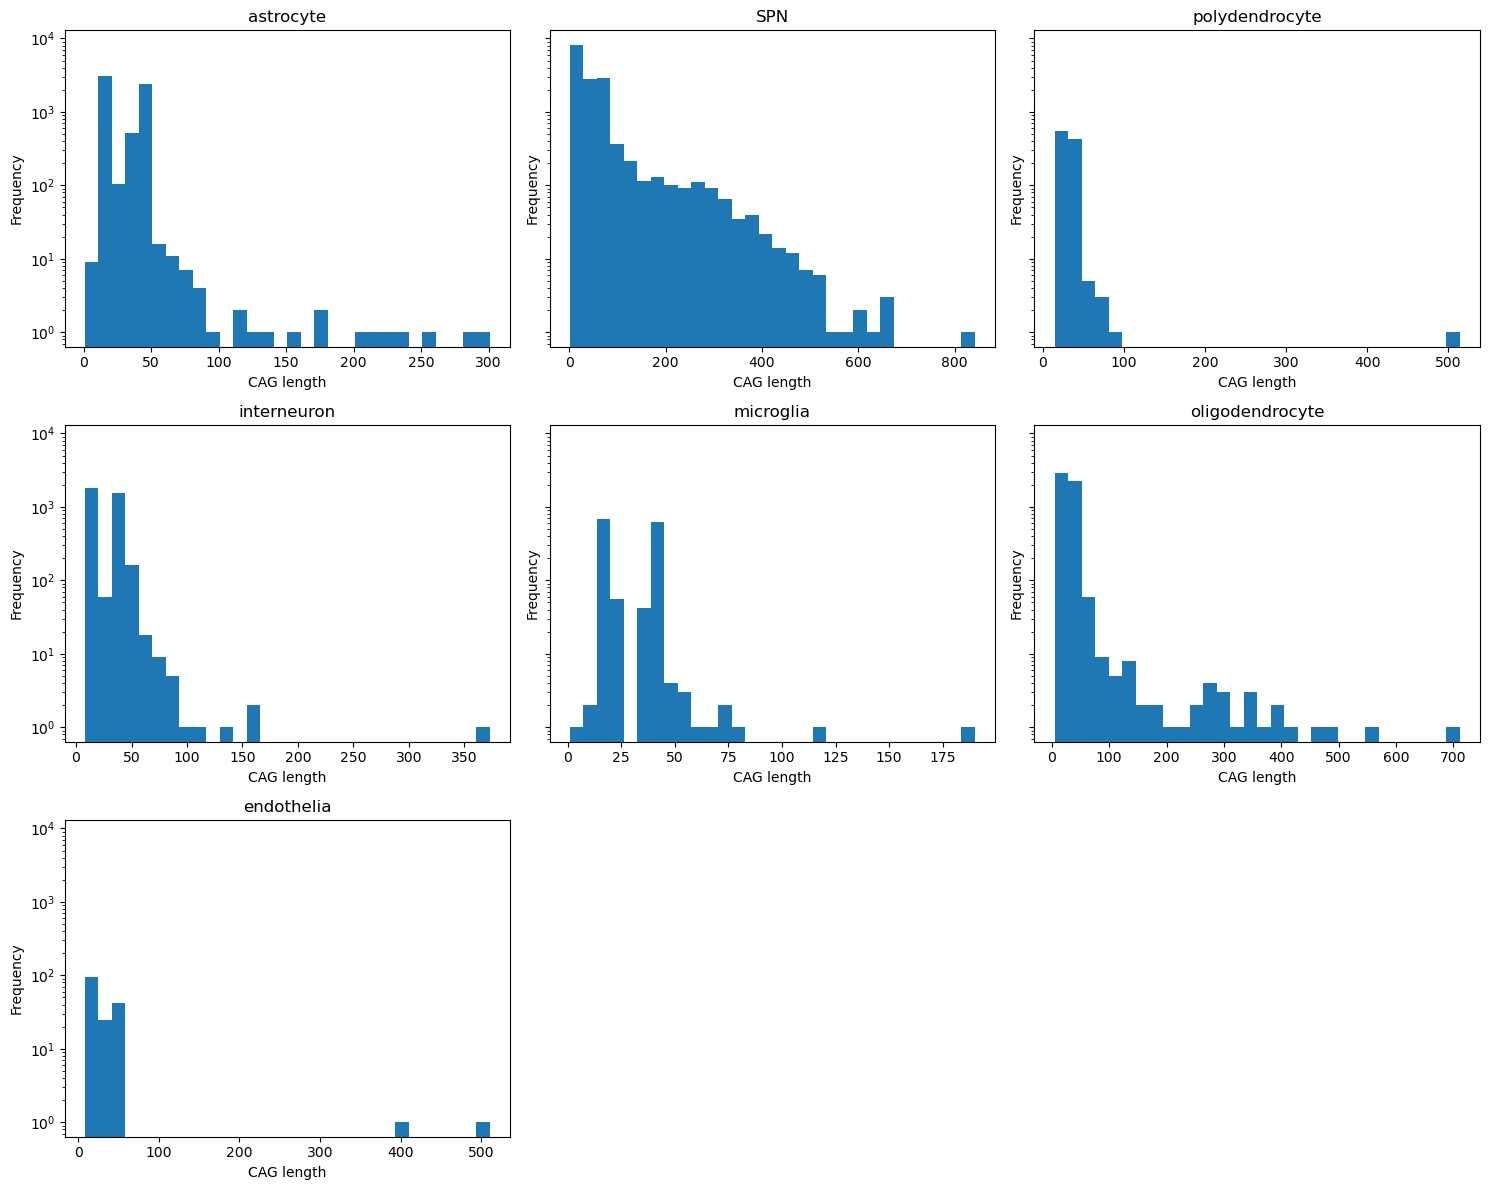

In [ ]:
# Histogram of CAG lengths per Cell Type

celltypes = pacbio['CELLTYPE'].unique()
n_types = len(celltypes)
ncols = 3
nrows = (n_types + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
axes = axes.flatten()

for i, celltype in enumerate(celltypes):
    ax = axes[i]
    subset = pacbio[pacbio['CELLTYPE'] == celltype]
    ax.hist(subset['CAGLENGTH'], bins=30)
    ax.set_yscale('log')
    ax.set_title(celltype)
    ax.set_xlabel('CAG length')
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [5]:
donor_metadata = pd.read_csv(f'{snrna_metadata_dir}donor_metadata.txt', sep='\t')
donor_metadata.head()

,Donor,SID,Age,Sex,Status,CAG,PMI,VS_Grade,Onset/Motor,Onset/Cog,CAP,CAP-100
0,1,S05202,67,Male,Case,15/42,23.36,HD-3,40.0,42.0,559,123.9
1,2,S12365,81,Female,Case,17/40,17.33,HD-0,75.0,NaN,514,124.8
2,3,S07681,69,Male,Case,16/42,18.16,HD-1,NaN,NaN,575,127.6
3,4,S06758,37,Female,Case,18/43,16.40,HD-1,NaN,NaN,346,74.1
4,5,S04002,58,Male,Case,17/42,13.45,HD-2,30.0,NaN,484,107.2


In [6]:
max_cag = pacbio.groupby('DONOR')['CAGLENGTH'].max()
mean_cag = pacbio.groupby('DONOR')['CAGLENGTH'].mean()

In [7]:
pacbio['DONOR'].unique()

array(['S05202', 'S12365', 'S04577', 'S07681', 'S06758', 'S04002',
       'S09619', 'S02205', 'S05368'], dtype=object)

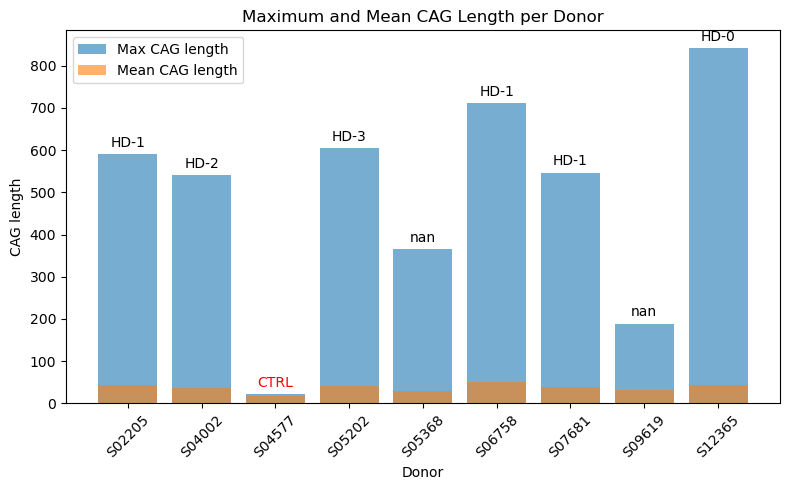

In [7]:
plt.figure(figsize=(8, 5))
bars = plt.bar(max_cag.index, max_cag.values, alpha=0.6, label='Max CAG length')
plt.bar(mean_cag.index, mean_cag.values, alpha=0.6, label='Mean CAG length')

for idx, donor in enumerate(max_cag.index):
    # Find matching donor row in donor_metadata
    donor_row = donor_metadata[donor_metadata['SID'] == donor]
    if not donor_row.empty and (donor_row['Status']!='Case').all():
        plt.text(idx, max_cag.values[idx] + 10, 'CTRL', ha='center', va='bottom', color='red', fontsize=10)
    else:
        plt.text(idx, max_cag.values[idx] + 10, donor_row['VS_Grade'].values[0], ha='center', va='bottom', color='black', fontsize=10)

plt.xlabel('Donor')
plt.ylabel('CAG length')
plt.legend()
plt.title('Maximum and Mean CAG Length per Donor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/pool01/projects/abante_lab/cag_propagation/presentation_figures/maximum_mean_cag_per_donor.svg')
plt.show()

## PACBio DeepDive

For 8 donors we have DeepDive RNA counts and CAG lengths at cell resolution. All samples except S04002 have snRNA data named as 

`<sample>_HD_Caudate_DeepDive_rxn<X>.umi_500-Inf_intronic_0.610-1.000.10X.exonic+intronic.h5`. 

Not all samples have the same number of runs. And S04002 is not DeepDive but 10X: 

`S04002_rxn5.umi_500-Inf_intronic_0.550-1.000.10X.exonic+intronic.h5` or 

`S04002_10X_rxn2_merged.umi_316-Inf_intronic_0.550-1.000.10X.exonic+intronic.h5`.

In [11]:
def c_read_h5(h5_file):
    # Load the data from the HDF5 file
    with h5py.File(h5_file, "r") as f:
        
        # Assuming structure like: matrix/data, matrix/indices, etc.
        data = f['matrix/data'][:]
        indices = f['matrix/indices'][:]
        indptr = f['matrix/indptr'][:]
        shape = f['matrix/shape'][:]

        # Create a sparse matrix from the data
        # Note: The original matrix is in CSC format, we convert it to CSR format
        matrix = sp.csc_matrix((data, indices, indptr), shape=shape).transpose().tocsr()

        # Extract barcodes and gene names
        barcodes = f['matrix/barcodes'][:].astype(str)
        gene_names = f['matrix/features/name'][:].astype(str)
        feature_type = f['matrix/features/feature_type'][:].astype(str) # All are gene expression

    # Construct AnnData object manually
    adata = ad.AnnData(X=matrix)
    adata.obs['BARCODE'] = barcodes
    adata.var_names = gene_names
    adata.obs['DONOR'] = h5_file.split('/')[-1].split('_')[0]
    
    # Cell barcode to match metadata barcode name
    prefix = h5_file.split('/')[-1].split('.')[0] 
    prefix_parts = prefix.split('_')
    prefix = '_'.join([prefix_parts[0]] + prefix_parts[2:])
    adata.obs['CELL_BARCODE'] = prefix + '_' + adata.obs['BARCODE']

    return adata

In [12]:
adata = c_read_h5(h5_file)
adata.obs

,BARCODE,DONOR,CELL_BARCODE
0,ATCACTTTCGGTCATA,S02205,S02205_Caudate_DeepDive_rxn1_ATCACTTTCGGTCATA
1,TCCTAATTCCACGGAC,S02205,S02205_Caudate_DeepDive_rxn1_TCCTAATTCCACGGAC
2,CCCTCTCTCGATTCCC,S02205,S02205_Caudate_DeepDive_rxn1_CCCTCTCTCGATTCCC
3,ATATCCTGTATGAGGC,S02205,S02205_Caudate_DeepDive_rxn1_ATATCCTGTATGAGGC
4,GAGACCCAGCCATATC,S02205,S02205_Caudate_DeepDive_rxn1_GAGACCCAGCCATATC
...,...,...,...
7829,GAGTCATGTAGGCAGT,S02205,S02205_Caudate_DeepDive_rxn1_GAGTCATGTAGGCAGT
7830,CCTTTGGAGGTCTGGA,S02205,S02205_Caudate_DeepDive_rxn1_CCTTTGGAGGTCTGGA
7831,GTGTTCCTCACGACTA,S02205,S02205_Caudate_DeepDive_rxn1_GTGTTCCTCACGACTA
7832,GTTCCGTTCCGGTAGC,S02205,S02205_Caudate_DeepDive_rxn1_GTTCCGTTCCGGTAGC


In [13]:
# Filter metadata for this sample
sample_pacbio = pacbio[pacbio['CELL_BARCODE'].isin(adata.obs['CELL_BARCODE'])]

# join metadata to AnnData object observation
adata.obs = adata.obs.set_index('CELL_BARCODE', drop=False)
adata.obs = adata.obs.join(sample_pacbio.set_index('CELL_BARCODE'), how='left', lsuffix='_snrnadata')

print(adata.X.shape)
adata = adata[adata.obs['CAGLENGTH'] == adata.obs['CAGLENGTH']]
print(adata.X.shape)

(7834, 35039)
(814, 35039)


/tmp/ipykernel_2231517/2578546506.py:26: RuntimeWarning: divide by zero encountered in divide
  expr_relative = expr_matrix / avg_expr
/tmp/ipykernel_2231517/2578546506.py:26: RuntimeWarning: invalid value encountered in divide
  expr_relative = expr_matrix / avg_expr


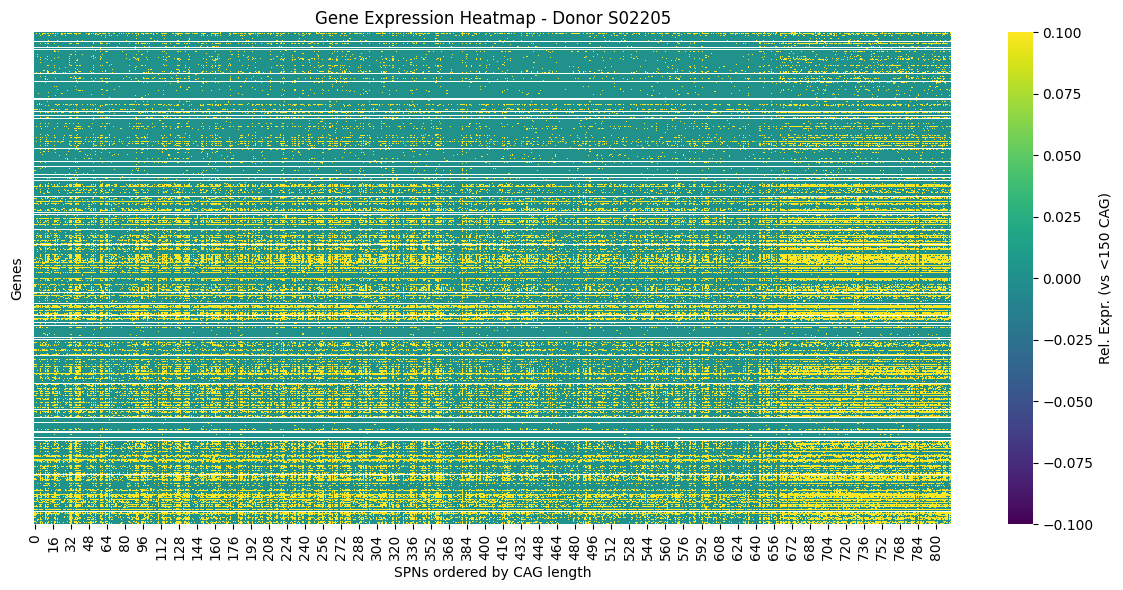

In [ ]:
# Select cells from one donor
donor_id = 'S02205'
adata_sub = adata[adata.obs['DONOR'] == donor_id].copy()

# Get CAG repeat length per cell
repeat_lengths = adata_sub.obs['CAGLENGTH']

genes_of_interest = adata_sub.var_names

# Normalize expression relative to average of cells with repeat length < 150
low_repeat_mask = repeat_lengths < 150
avg_expr = adata_sub[low_repeat_mask, genes_of_interest].X.mean(axis=0)

# Ensure data is dense
if not isinstance(avg_expr, np.ndarray):
    avg_expr = avg_expr.A1

# Extract expression and normalize
expr_matrix = adata_sub[:, genes_of_interest].X
if not isinstance(expr_matrix, np.ndarray):
    expr_matrix = expr_matrix.toarray()

expr_relative = expr_matrix / avg_expr

# Order columns by repeat length
order = np.argsort(repeat_lengths)
ordered_expr = expr_relative[order, :].T  # rows = genes, columns = SPNs

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(ordered_expr, cmap='viridis', yticklabels=False, cbar_kws={'label': 'Rel. Expr. (vs <150 CAG)'})
plt.title(f'Gene Expression Heatmap - Donor {donor_id}')
plt.xlabel('SPNs ordered by CAG length')
plt.ylabel('Genes')
plt.tight_layout()
plt.show()

### scRNA-seq data

In [ ]:
with h5py.File(f"{snrna_counts_dir}CHDI_Village14_rxn1.umi_500-Inf_intronic_0.550-1.000.10X.exonic+intronic.donors.h5", "r") as f:
    # Assuming structure like: matrix/data, matrix/indices, etc.
    data = f['matrix/data'][:]
    indices = f['matrix/indices'][:]
    indptr = f['matrix/indptr'][:]
    shape = f['matrix/shape'][:]

    matrix = sp.csr_matrix((data, indices, indptr), shape=shape)

    barcodes = f['matrix/barcodes'][:].astype(str)
    gene_names = f['matrix/features/name'][:].astype(str)
    gene_ids = f['matrix/features/id'][:].astype(str)

# Construct AnnData object manually
adata = ad.AnnData(X=matrix)
adata.obs_names = barcodes
adata.var_names = gene_names
adata.var["gene_ids"] = gene_ids

If the final datasets are already assembled, read the AnnData object directly instead (more efficient):

In [46]:
# Supervised dataset
dataset_path="projects/abante_lab/cag_propagation/deep_dive_adata_v2_6k.h5"

# Semi-supervised dataset (50% missing labels)
dataset_path="projects/abante_lab/cag_propagation/deep_dive_10x_v1_6k_test0.5_adata.h5"

# Load the dataset
adata = ad.read_h5ad(dataset_path)

# Copy obs data
df = adata.obs.copy()

Here we see the distribution of the cells along the cell type label, and how CAG somatic expansion changes across cells per cell type, both the exact nuber of repetitions and the categories.

/tmp/ipykernel_3577010/378191137.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipykernel_3577010/378191137.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


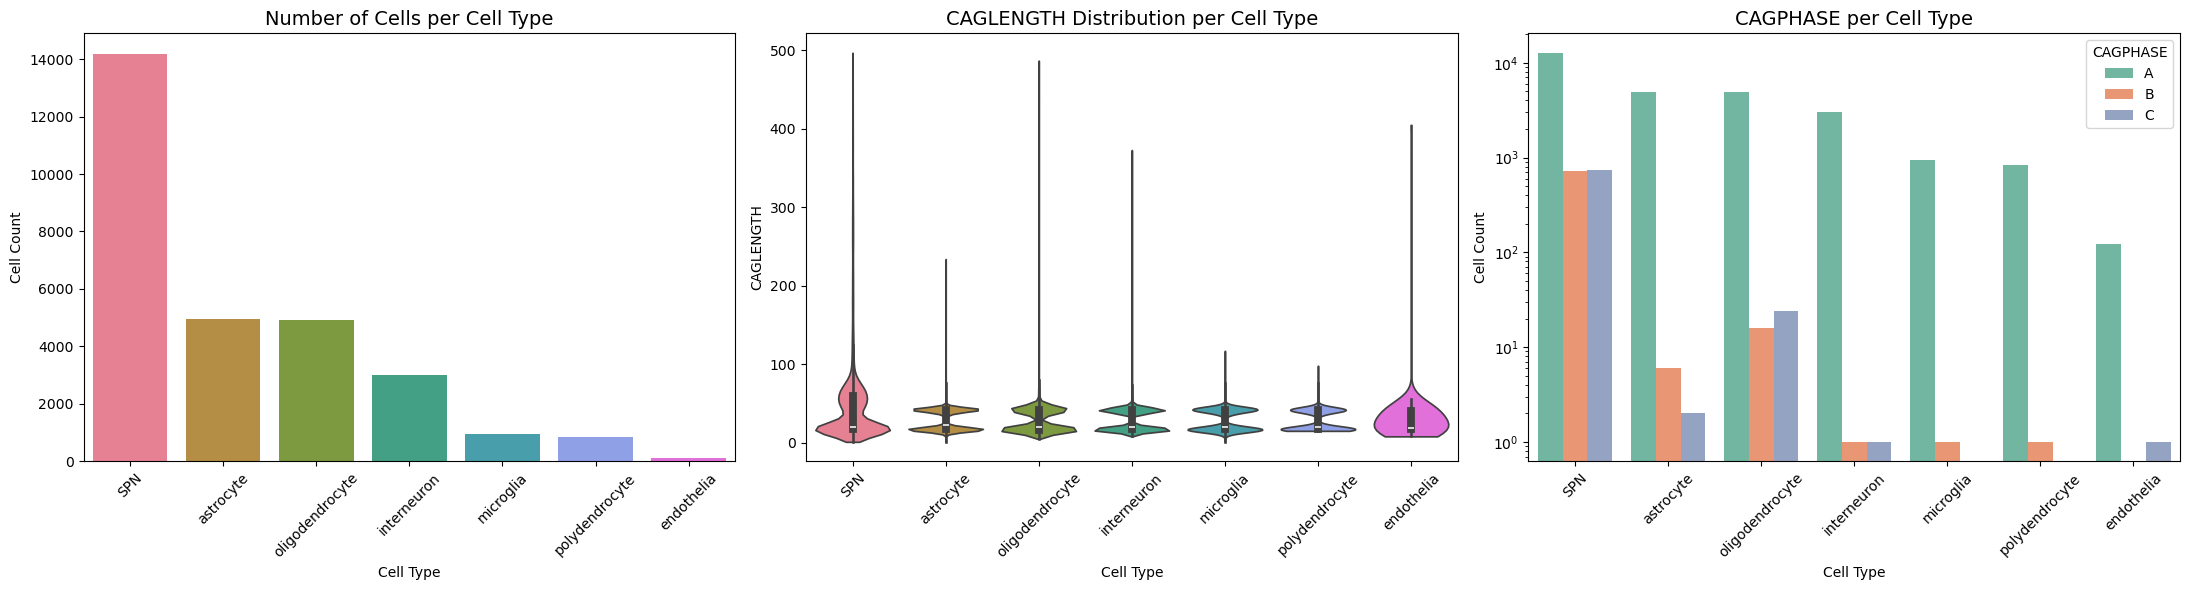

In [ ]:
# Make sure the needed columns exist
for col in ['CELLTYPE', 'CAGLENGTH', 'CAGPHASE']:
    if col not in df.columns:
        raise ValueError(f"adata.obs must contain '{col}' column.")

# Compute counts per celltype to control order
celltype_order = (
    df['CELLTYPE']
    .value_counts()
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Create consistent color map for cell types
palette_ct = sns.color_palette("husl", n_colors=len(celltype_order))
color_map_ct = dict(zip(celltype_order, palette_ct))

fig, axes = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.4)

#  Bar plot of cell counts 
sns.countplot(
    data=df,
    x='CELLTYPE',
    order=celltype_order,
    palette=color_map_ct,
    ax=axes[0]
)
axes[0].set_title("Number of Cells per Cell Type", fontsize=14)
axes[0].set_xlabel("Cell Type")
axes[0].set_ylabel("Cell Count")
axes[0].tick_params(axis='x', rotation=45)

# Violin plot of CAGLENGTH per Cell Type 
sns.violinplot(
    data=df,
    x='CELLTYPE',
    y='CAGLENGTH',
    order=celltype_order,
    palette=color_map_ct,
    ax=axes[1],
    inner='box',
    cut=0
)
axes[1].set_title("CAGLENGTH Distribution per Cell Type", fontsize=14)
axes[1].set_xlabel("Cell Type")
axes[1].set_ylabel("CAGLENGTH")
axes[1].tick_params(axis='x', rotation=45)

# Bars of counts by CAGPHASE (excluding D)
# Count cells by CELLTYPE and CAGPHASE
phase_counts = (
    df.groupby(['CELLTYPE', 'CAGPHASE'])
    .size()
    .reset_index(name='count')
)

# Ensure consistent category ordering
phase_counts['CELLTYPE'] = pd.Categorical(phase_counts['CELLTYPE'], categories=celltype_order, ordered=True)

# Choose a bright, distinct palette for CAGPHASE bars
phase_palette = sns.color_palette("Set2", n_colors=phase_counts['CAGPHASE'].nunique())

sns.barplot(
    data=phase_counts,
    x='CELLTYPE',
    y='count',
    hue='CAGPHASE',
    order=celltype_order,
    palette=phase_palette,
    ax=axes[2]
)

axes[2].set_title("CAGPHASE per Cell Type", fontsize=14)
axes[2].set_xlabel("Cell Type")
axes[2].set_ylabel("Cell Count")
axes[2].set_yscale('log')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title="CAGPHASE", loc='upper right', frameon=True)

plt.tight_layout()
plt.show()



/tmp/ipykernel_3804522/957936937.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['CELLTYPE', 'CAGPHASE'])


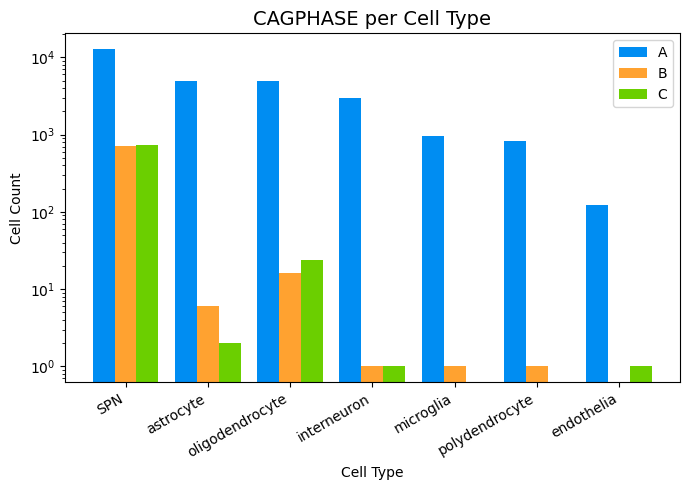

In [10]:
# Required columns
for col in ['CELLTYPE', 'CAGLENGTH', 'CAGPHASE']:
    if col not in df.columns:
        raise ValueError(f"adata.obs must contain '{col}' column.")

# Compute counts per celltype to control order
celltype_order = (
    df['CELLTYPE']
    .value_counts()
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Count cells by CELLTYPE and CAGPHASE 

phase_counts = (
    df.groupby(['CELLTYPE', 'CAGPHASE'])
    .size()
    .reset_index(name='count')
)

# Ensure consistent category ordering
phase_counts['CELLTYPE'] = pd.Categorical(phase_counts['CELLTYPE'], categories=celltype_order, ordered=True)

# Choose a bright, distinct palette for CAGPHASE bars
# phase_palette = sns.color_palette("Set2", n_colors=phase_counts['CAGPHASE'].nunique())
phase_color_map = {
    "A": "#008df2", 
    "B": "#ffa230", 
    "C": "#6bcf00", 
}
phase_order = sorted(phase_counts['CAGPHASE'].unique())

fig, ax = plt.subplots(figsize=(7, 5))

# Make backgrounds transparent
fig.patch.set_alpha(0)
ax.set_facecolor("none")
# Bar positioning
x = np.arange(len(celltype_order))
bar_width = 0.8 / len(phase_order)

# Plot grouped bars
for i, phase in enumerate(phase_order):
    subset = phase_counts[phase_counts['CAGPHASE'] == phase]
    counts = [
        subset.loc[subset['CELLTYPE'] == ct, 'count'].values[0]
        if ct in subset['CELLTYPE'].values else 0
        for ct in celltype_order
    ]

    ax.bar(
        x + i * bar_width,
        counts,
        width=bar_width,
        label=phase,
        color=phase_color_map.get(phase, "#999999")
    )

# Axes formatting
ax.set_title("CAGPHASE per Cell Type", fontsize=14)
ax.set_xlabel("Cell Type")
ax.set_ylabel("Cell Count")
ax.set_yscale("log")
ax.set_xticks(x + bar_width * (len(phase_order) - 1) / 2)
ax.set_xticklabels(celltype_order, rotation=30, ha="right")

ax.legend()
plt.tight_layout()

plt.savefig(
    "/pool01/projects/abante_lab/cag_propagation/presentation_figures/CAGPHASE_celltype_plot.pdf",
    dpi=600,
    bbox_inches="tight",
    # transparent=True
)

plt.show()


#### How technology and cell type is the main source of variability in scRNA-seq data

In [47]:
# Scale (zero mean, unit variance)
sc.pp.scale(adata, max_value=10)

# PCA
sc.tl.pca(adata, svd_solver="arpack")

/pool01/conda/envs/cag_snRNA/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


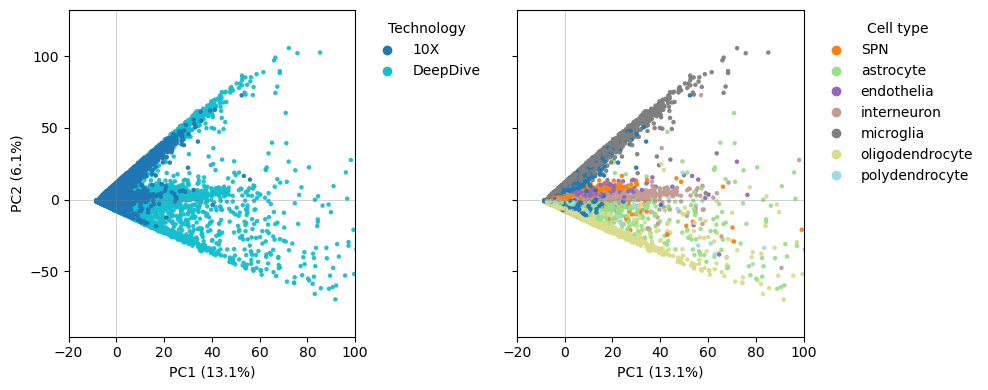

In [48]:
pc1 = adata.obsm["X_pca"][:, 0]
pc2 = adata.obsm["X_pca"][:, 1]

# Set PC1 limits
pc1_min, pc1_max = -20, 100

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Technology
tech = adata.obs["TECHNOLOGY"].astype("category")
tech_codes = tech.cat.codes
tech_cats = tech.cat.categories

sc1 = axes[0].scatter(
    pc1, pc2,
    c=tech_codes,
    s=5,
    alpha=0.9,
    rasterized=True,
    cmap="tab10"
)

tech_handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=sc1.cmap(sc1.norm(i)),
               label=cat)
    for i, cat in enumerate(tech_cats)
]

axes[0].legend(
    handles=tech_handles,
    title="Technology",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

# axes[0].set_title("Colored by technology")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

#  Cell type
celltype = adata.obs["CELLTYPE"].astype("category")
ct_codes = celltype.cat.codes
ct_cats = celltype.cat.categories

sc2 = axes[1].scatter(
    pc1, pc2,
    c=ct_codes,
    s=5,
    alpha=0.9,
    rasterized=True,
    cmap="tab20"
)

ct_handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=sc2.cmap(sc2.norm(i)),
               label=cat)
    for i, cat in enumerate(ct_cats)
]

axes[1].legend(
    handles=ct_handles,
    title="Cell type",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

# axes[1].set_title("Colored by cell type")
axes[1].set_xlabel("PC1")

for ax in axes:
    ax.set_xlim(pc1_min, pc1_max)
    ax.axvline(0, color="grey", lw=0.5, alpha=0.5)
    ax.axhline(0, color="grey", lw=0.5, alpha=0.5)

var = adata.uns["pca"]["variance_ratio"]
axes[0].set_xlabel(f"PC1 ({var[0]*100:.1f}%)")
axes[0].set_ylabel(f"PC2 ({var[1]*100:.1f}%)")
axes[1].set_xlabel(f"PC1 ({var[0]*100:.1f}%)")

plt.tight_layout()
plt.savefig("/pool01/projects/abante_lab/cag_propagation/presentation_figures/edaPCA.pdf",
    dpi=300,
    bbox_inches="tight")
plt.show()


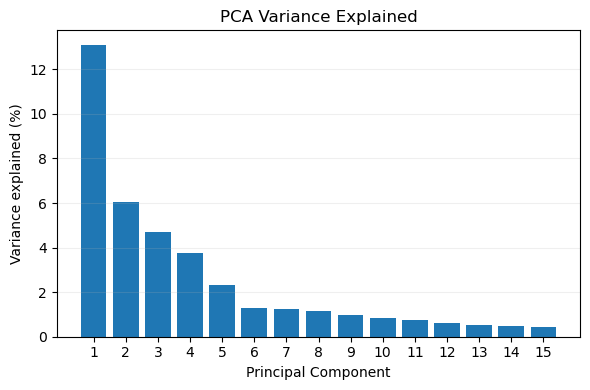

In [26]:
var = adata.uns["pca"]["variance_ratio"][:15]
pcs = np.arange(1, len(var) + 1)

plt.figure(figsize=(6, 4))
plt.grid(axis='y', alpha = 0.2)
plt.bar(pcs, var * 100)
plt.xlabel("Principal Component")
plt.ylabel("Variance explained (%)")
plt.title("PCA Variance Explained")
plt.xticks(pcs)
plt.tight_layout()

plt.savefig(
    "/pool01/projects/abante_lab/cag_propagation/presentation_figures/multitech_pca_variance_explained.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [35]:
adata = adata[adata.obs['TECHNOLOGY'] != '10X']

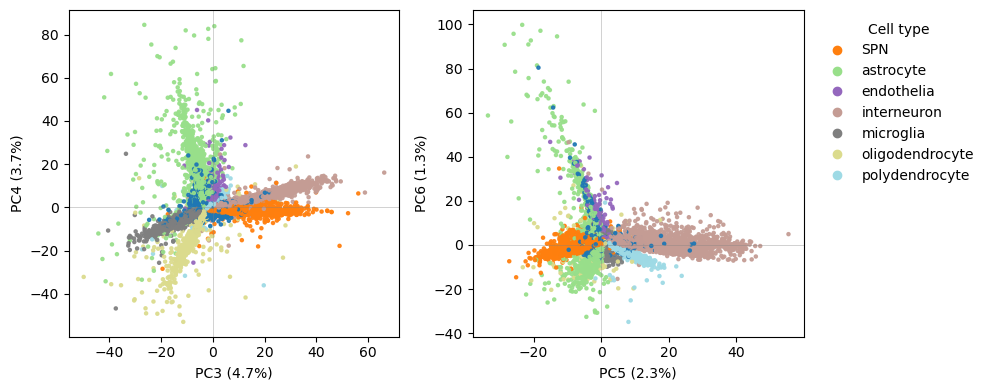

In [59]:
# Extract PCs
X_pca = adata.obsm["X_pca"]

pc3, pc4 = X_pca[:, 2], X_pca[:, 3]
pc5, pc6 = X_pca[:, 4], X_pca[:, 5]

var = adata.uns["pca"]["variance_ratio"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

celltype = adata.obs["CELLTYPE"].astype("category")
ct_codes = celltype.cat.codes
ct_cats = celltype.cat.categories

# PC3 vs PC4
sc1 = axes[0].scatter(
    pc3, pc4,
    c=ct_codes,
    s=5,
    alpha=0.9,
    rasterized=True,
    cmap="tab20"
)

axes[0].set_xlabel(f"PC3 ({var[2]*100:.1f}%)")
axes[0].set_ylabel(f"PC4 ({var[3]*100:.1f}%)")
axes[0].axvline(0, color="grey", lw=0.5, alpha=0.5)
axes[0].axhline(0, color="grey", lw=0.5, alpha=0.5)

# PC5 vs PC6
sc2 = axes[1].scatter(
    pc5, pc6,
    c=ct_codes,
    s=5,
    alpha=0.9,
    rasterized=True,
    cmap="tab20"
)

axes[1].set_xlabel(f"PC5 ({var[4]*100:.1f}%)")
axes[1].set_ylabel(f"PC6 ({var[5]*100:.1f}%)")
axes[1].axvline(0, color="grey", lw=0.5, alpha=0.5)
axes[1].axhline(0, color="grey", lw=0.5, alpha=0.5)

# Legend (shared)
ct_handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=sc1.cmap(sc1.norm(i)),
               label=cat)
    for i, cat in enumerate(ct_cats)
]

axes[1].legend(
    handles=ct_handles,
    title="Cell type",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.savefig(
    "/pool01/projects/abante_lab/cag_propagation/presentation_figures/edaPCA_PC3_PC6.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [50]:
adata.obs['CAGPHASE'].value_counts()

CAGPHASE
A    27481
C      761
B      741
Name: count, dtype: int64

In [60]:
X_pca = adata.obsm["X_pca"]
pc3, pc4 = X_pca[:, 2], X_pca[:, 3]
pc5, pc6 = X_pca[:, 4], X_pca[:, 5]

var = adata.uns["pca"]["variance_ratio"]

phase = adata.obs["CAGPHASE"]

mask_unlabeled = phase.isna()
mask_A = phase == "A"
mask_B = phase == "B"
mask_C = phase == "C"

colors = {
    "A": "#008df2", 
    "B": "#ffa230", 
    "C": "#6bcf00",
    "unlabeled": "#d0d0d0"
}

alpha = {
    "unlabeled": 0.15,
    "A": 0.35,
    "B": 0.9,
    "C": 0.9
}

size = {
    "unlabeled": 4,
    "A": 4,
    "B": 6,
    "C": 6
}


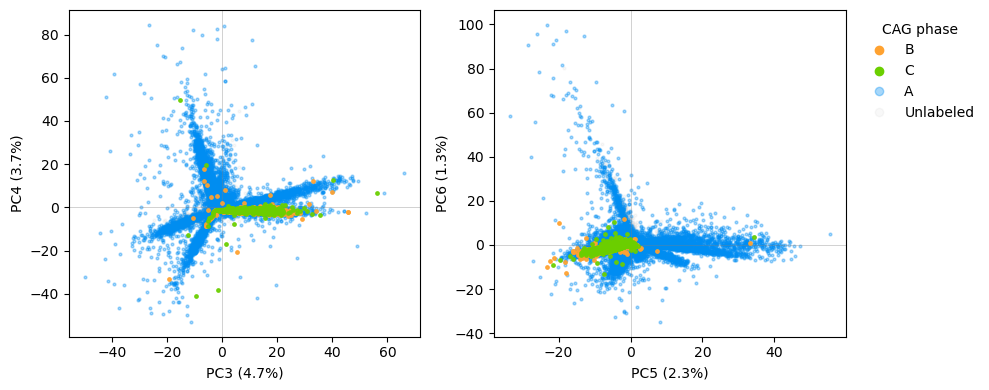

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]

# Bottom layer: unlabeled
ax.scatter(
    pc3[mask_unlabeled], pc4[mask_unlabeled],
    c=colors["unlabeled"], s=size["unlabeled"],
    alpha=alpha["unlabeled"], rasterized=True, zorder=1
)

# Phase A
ax.scatter(
    pc3[mask_A], pc4[mask_A],
    c=colors["A"], s=size["A"],
    alpha=alpha["A"], rasterized=True, zorder=2, label="A"
)

# Phase B
ax.scatter(
    pc3[mask_B], pc4[mask_B],
    c=colors["B"], s=size["B"],
    alpha=alpha["B"], rasterized=True, zorder=3, label="B"
)

# Phase C
ax.scatter(
    pc3[mask_C], pc4[mask_C],
    c=colors["C"], s=size["C"],
    alpha=alpha["C"], rasterized=True, zorder=3, label="C"
)

ax.set_xlabel(f"PC3 ({var[2]*100:.1f}%)")
ax.set_ylabel(f"PC4 ({var[3]*100:.1f}%)")
ax.axvline(0, color="grey", lw=0.5, alpha=0.5)
ax.axhline(0, color="grey", lw=0.5, alpha=0.5)


ax = axes[1]

ax.scatter(
    pc5[mask_unlabeled], pc6[mask_unlabeled],
    c=colors["unlabeled"], s=size["unlabeled"],
    alpha=alpha["unlabeled"], rasterized=True, zorder=1
)

ax.scatter(
    pc5[mask_A], pc6[mask_A],
    c=colors["A"], s=size["A"],
    alpha=alpha["A"], rasterized=True, zorder=2
)

ax.scatter(
    pc5[mask_B], pc6[mask_B],
    c=colors["B"], s=size["B"],
    alpha=alpha["B"], rasterized=True, zorder=3
)

ax.scatter(
    pc5[mask_C], pc6[mask_C],
    c=colors["C"], s=size["C"],
    alpha=alpha["C"], rasterized=True, zorder=3
)

ax.set_xlabel(f"PC5 ({var[4]*100:.1f}%)")
ax.set_ylabel(f"PC6 ({var[5]*100:.1f}%)")
ax.axvline(0, color="grey", lw=0.5, alpha=0.5)
ax.axhline(0, color="grey", lw=0.5, alpha=0.5)


legend_handles = [
    Line2D([], [], marker="o", linestyle="",
           color=colors["B"], markersize=6, label="B"),
    Line2D([], [], marker="o", linestyle="",
           color=colors["C"], markersize=6, label="C"),
    Line2D([], [], marker="o", linestyle="",
           color=colors["A"], markersize=6, alpha=alpha["A"], label="A"),
    Line2D([], [], marker="o", linestyle="",
           color=colors["unlabeled"], markersize=6,
           alpha=alpha["unlabeled"], label="Unlabeled"),
]

axes[1].legend(
    handles=legend_handles,
    title="CAG phase",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.savefig(
    "/pool01/projects/abante_lab/cag_propagation/presentation_figures/edaPCA_PC3_PC6_CAGPHASE.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


## snRNA data (no CAG at cell resolution)

First, read in metadata with all cells. This only needs to be done once since it contains metadata for all cells!

In [9]:
cell_meta=f'{snrna_metadata_dir}10x_village_cell_metadata.txt'
cell_meta = pd.read_csv(cell_meta, sep='\t')
cell_meta

,PREFIX,CBC,CELL_BARCODE,predClass,max.prob,DONOR,NUM_GENIC_READS,NUM_TRANSCRIPTS,NUM_GENES
0,Village1_rxn1,TACGTCCCACTAACCA,Village1_rxn1_TACGTCCCACTAACCA,SPN,1.0,S17094,196791,53217,7831
1,Village1_rxn1,CCCTCAATCACCCTCA,Village1_rxn1_CCCTCAATCACCCTCA,SPN,1.0,S02574,144034,38141,7514
2,Village1_rxn1,AAGATAGTCTATCGTT,Village1_rxn1_AAGATAGTCTATCGTT,SPN,1.0,S01733,138626,38099,7036
3,Village1_rxn1,GAGACTTAGATCCAAA,Village1_rxn1_GAGACTTAGATCCAAA,SPN,1.0,S01780,122879,36720,6466
4,Village1_rxn1,ACCCAAAGTCTTTCAT,Village1_rxn1_ACCCAAAGTCTTTCAT,SPN,1.0,S02574,127869,36804,7262
...,...,...,...,...,...,...,...,...,...
581268,Village8_rxn8,GAGGCCTGTGAGTCAG,Village8_rxn8_GAGGCCTGTGAGTCAG,polydendrocyte,1.0,S08680,8110,3548,2038
581269,Village8_rxn8,GTGTCCTAGTATCCTG,Village8_rxn8_GTGTCCTAGTATCCTG,polydendrocyte,1.0,S14094,7163,3345,1858
581270,Village8_rxn8,AGGCCACAGAGCAGTC,Village8_rxn8_AGGCCACAGAGCAGTC,polydendrocyte,1.0,S17712,5163,2355,1564
581271,Village8_rxn8,TGAGCGCGTGAGGAAA,Village8_rxn8_TGAGCGCGTGAGGAAA,polydendrocyte,1.0,S14094,4440,2179,1405


In [11]:
'S04002' in (cell_meta['DONOR'])

False

In [10]:
cell_meta['DONOR'].unique().shape

(103,)

Then we can read in the actual counts from each combination (village,runx). Here is an example for a single combination:

In [ ]:
# Selected cells counts (cells were selected for analysis using minimum UMI and percent intronic transcripts 
# thresholds after Cell Bender Remove Background was applied, then filtered to only contain cell barcodes 
# that were confidently assigned to a single donor. These counts files contain the string "donors").
in_file = f"{snrna_counts_dir}/CHDI_Village14_rxn1.umi_500-Inf_intronic_0.550-1.000.10X.exonic+intronic.donors.h5"

# Load the data from the HDF5 file
with h5py.File(in_file, "r") as f:
    
    # Assuming structure like: matrix/data, matrix/indices, etc.
    data = f['matrix/data'][:]
    indices = f['matrix/indices'][:]
    indptr = f['matrix/indptr'][:]
    shape = f['matrix/shape'][:]

    # Create a sparse matrix from the data
    # Note: The original matrix is in CSC format, we convert it to CSR format
    matrix = sp.csc_matrix((data, indices, indptr), shape=shape).transpose().tocsr()

    # Extract barcodes and gene names
    barcodes = f['matrix/barcodes'][:].astype(str)
    gene_names = f['matrix/features/name'][:].astype(str)
    feature_type = f['matrix/features/feature_type'][:].astype(str) # All are gene expression

# Construct AnnData object manually
adata = ad.AnnData(X=matrix)
adata.obs_names = barcodes
adata.var_names = gene_names

# filter metadata from cell_meta subsetting for Village 14
sample_cell_meta = cell_meta[cell_meta['PREFIX'].str.contains('Village14_rxn1')]

# keep only the cell barcodes in cell_meta present in the AnnData object
sample_cell_meta = sample_cell_meta[sample_cell_meta['CBC'].isin(adata.obs_names)]

# join metadata to AnnData object observation
adata.obs = adata.obs.join(sample_cell_meta.set_index('CBC'), how='left')

adata.obs

,PREFIX,CELL_BARCODE,predClass,max.prob,DONOR,NUM_GENIC_READS,NUM_TRANSCRIPTS,NUM_GENES
ATCACTTCAGAGGCAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GGCTGTGCAGGAATCG,Village14_rxn1,Village14_rxn1_GGCTGTGCAGGAATCG,interneuron,1.000,S15245,146180.0,61913.0,8952.0
CTCACTGAGGGCTTCC,Village14_rxn1,Village14_rxn1_CTCACTGAGGGCTTCC,SPN,0.999,S06720,129090.0,57358.0,7661.0
AATCGACCATCTCCCA,Village14_rxn1,Village14_rxn1_AATCGACCATCTCCCA,SPN,1.000,S06758,112907.0,52037.0,7498.0
TCGACCTTCTGCTTTA,Village14_rxn1,Village14_rxn1_TCGACCTTCTGCTTTA,SPN,1.000,S13957,107467.0,48520.0,7795.0
...,...,...,...,...,...,...,...,...
TGTCCCACATTATGCG,Village14_rxn1,Village14_rxn1_TGTCCCACATTATGCG,oligodendrocyte,1.000,S00002,3586.0,1425.0,881.0
TAACACGAGTGCAAAT,Village14_rxn1,Village14_rxn1_TAACACGAGTGCAAAT,oligodendrocyte,0.999,S19232,3757.0,1465.0,875.0
CTCATTAAGCGTTGTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGAGAAGGTGATGGCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For this data we do not have CAG information for each cell, just the inherited CAG length for each donor.

Let's inspect the nature of the cells with NaN metadata values.

In [12]:
# Read small version of full dataset
adata = ad.read_h5ad("projects/abante_lab/cag_propagation/deep_dive_10x_test0.1_adata.h5")

In [13]:
# Subset 10X cells
adata = adata[adata.obs['TECHNOLOGY'] == '10X']

In [16]:
adata[adata.obs['CELLTYPE'].isnull()].obs

,BARCODE,CELL_BARCODE,PREFIX,CBC,CELLTYPE,max.prob,DONOR,NUM_GENIC_READS,NUM_TRANSCRIPTS,NUM_GENES,...,UMI,NREADS,READLENGTH,CAGLENGTH,CATEGORY,ALIGNSTART,ALIGNEND,REGION,CAGPHASE,TECHNOLOGY
CELL_BARCODE,,,,,,,,,,,,,,,,,,,,,
Village1_rxn1_CGATCGGCACACACGC,CGATCGGCACACACGC,Village1_rxn1_CGATCGGCACACACGC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X
Village5_rxn4_GACCCTTCACAAATAG,GACCCTTCACAAATAG,Village5_rxn4_GACCCTTCACAAATAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X
Village1_rxn5_CTCAGTCCAGACATCT,CTCAGTCCAGACATCT,Village1_rxn5_CTCAGTCCAGACATCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X
Village4_rxn5_AGGATAAGTCTTTATC,AGGATAAGTCTTTATC,Village4_rxn5_AGGATAAGTCTTTATC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X
Village14_rxn3_CGTGAATTCTTAGGAC,CGTGAATTCTTAGGAC,Village14_rxn3_CGTGAATTCTTAGGAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Village8_rxn1_TTCAGGATCTGCGAGC,TTCAGGATCTGCGAGC,Village8_rxn1_TTCAGGATCTGCGAGC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X
Village20_rxn8_TAACTTCGTACGGGAT,TAACTTCGTACGGGAT,Village20_rxn8_TAACTTCGTACGGGAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X
Village4_rxn3_TAGACCAGTCCGAAAG,TAGACCAGTCCGAAAG,Village4_rxn3_TAGACCAGTCCGAAAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10X


In [13]:
adata[adata.obs['CELLTYPE'].isnull()].obs['NREADS'].isnull().sum()


9829

In [ ]:
# Check subset of count matrix of these cells
adata[adata.obs['CELLTYPE'].isnull()].X[:2, ].toarray().sum(axis=1)

array([ 34, 928])

The Nan celltypes are cells with no metadata, but with counts. This won't be a problem for the model we test it on, as DCAG can be trained with cells with no labels.